<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Sentiment analysis con Embeddings + LSTM

### Objetivo
El objetivo es utilizar las críticas de compradores de ropa para que el sistema determine la evaluación del comprador y su crítica (cuantas estrellas le asigna al producto).

In [1]:
!pip install --upgrade --no-cache-dir gdown --quiet

In [5]:
import numpy as np
import random
import io
import pickle
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.utils import to_categorical
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding

### Datos
Utilizaremos como dataset críticas de compradores de ropa (eCommerce) los cuales puntuaron a cada prenda con un puntaje de 1 a 5 estrellas.\
Referencia del dataset: [LINK](https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews/version/1)

In [6]:
# Descargar la carpeta de dataset
import os
import gdown
if os.access('clothing_ecommerce_reviews.csv', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1Urn1UFSrodN5BuW6-sc_igtaySGRwhV8'
    output = 'clothing_ecommerce_reviews.csv'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

Downloading...
From: https://drive.google.com/uc?id=1Urn1UFSrodN5BuW6-sc_igtaySGRwhV8
To: /content/clothing_ecommerce_reviews.csv
100%|██████████| 8.48M/8.48M [00:00<00:00, 45.1MB/s]


In [7]:
# Armar el dataset
df = pd.read_csv('clothing_ecommerce_reviews.csv')
df.drop(columns = ['Unnamed: 0'], inplace = True)
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


### 1 - Limpieza de datos
Alumno:
- Del dataset unicamente utilizar las columnas "Review Text" y "Rating.
- Tranformar el rating 1-5 a una escala numérica de 0 a 4.



In [8]:
df_reviews = df.loc[:, ['Review Text', 'Rating']].dropna()
df_reviews['Rating'] = df_reviews['Rating'] - 1
df_reviews.head()

,Review Text,Rating
0,Absolutely wonderful - silky and sexy and comf...,3
1,Love this dress! it's sooo pretty. i happene...,4
2,I had such high hopes for this dress and reall...,2
3,"I love, love, love this jumpsuit. it's fun, fl...",4
4,This shirt is very flattering to all due to th...,4


<Axes: >

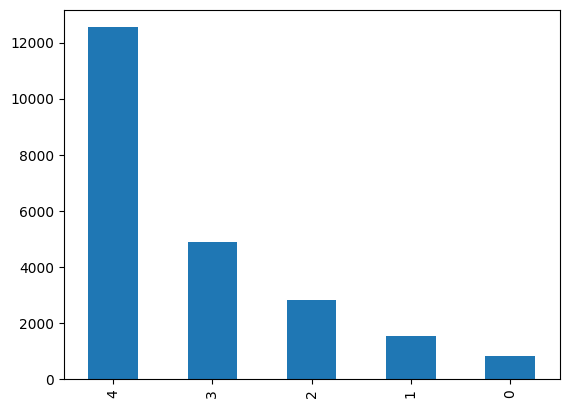

In [11]:
# Alumno: Observar como está distribuido el dataset respecto a la columna Rating
# es decir, observar que tan balanceado se encuentra respecot a cada clase
df_reviews['Rating'].value_counts().plot(kind="bar")

In [12]:
# Alumno: tomar la columna de las review y almacenarlo todo en un vector numpy de reviews
reviews = df_reviews['Review Text'].values

In [13]:
# Alumno: Cuantas reviews (rows) hay para evaluar?
print("Número de reviews:", len(reviews))

Número de reviews: 22641


In [14]:
# Alumno: Concatenar todas las reviews para armar el corpus
corpus = ' '.join(reviews)

In [15]:
# Alumno: ¿Cuál es la longitud de ese corpus?
print("Longitud del corpus:", len(corpus))

Longitud del corpus: 7011643


In [16]:
# Alumno: Utilizar "text_to_word_sequence" para separar las palabras en tokens
# recordar que text_to_word_sequence automaticamente quita los signos de puntuacion y pasa el texto a lowercase
from keras.preprocessing.text import text_to_word_sequence
tokens = text_to_word_sequence(corpus)

In [17]:
# Alumno: Dar un vistazo a los primeros 20 tokens/palabras
print("Primeros 20 tokens:", tokens[:20])

Primeros 20 tokens: ['absolutely', 'wonderful', 'silky', 'and', 'sexy', 'and', 'comfortable', 'love', 'this', 'dress', "it's", 'sooo', 'pretty', 'i', 'happened', 'to', 'find', 'it', 'in', 'a']


In [18]:
# Alumno: ¿Cuántos tokens/palabras hay?
print("Número de tokens:", len(tokens))

Número de tokens: 1372203


In [19]:
# Alumno: Tokenizar las palabras con el Tokenizer de Keras
# Definir una máxima cantidad de palabras a utilizar:
# num_words --> the maximum number of words to keep, based on word frequency.
# Only the most common num_words-1 words will be kept.
from keras.preprocessing.text import Tokenizer
num_words = 2000
vocab_size = num_words
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(corpus)
sequences = tokenizer.texts_to_sequences(corpus)

In [20]:
# Alumno: Obtener el diccionario de palabra (word) a índice
# y observar la cantidad total del vocabulario
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 44 unique tokens.


In [22]:
# Alumno: Convertir las palabras/tokens a números
individual_sequences = tokenizer.texts_to_sequences(reviews)

In [25]:
# Alumno: Determinar cual es la oración más larga
max_len = 0
index_of_max_len = 0
for i, seq in enumerate(individual_sequences):
    if len(seq) > max_len:
        max_len = len(seq)
        index_of_max_len = i
print("La oración más larga es la review número",
      index_of_max_len + 1, "con una longitud de",
      max_len, "palabras.")
print("Review:", reviews[index_of_max_len])

La oración más larga es la review número 5182 con una longitud de 25 palabras.
Review: I just received these sweaters............couldn't decide which color i liked best....blue and green are my favs.
and so i ordered them both!
they are a wow !
i am totally in love with both of them.
they are sooooooooooooooo beautiful!
beyond my wildest expectations!
i wear a size 8 and ordered the size 2 and it fits perfectly......a 2 is a size medium per call to retailer before i ordered.....and 1 is small, ad 0 is extra small.
this is a bulky, cuddly winter sweater with a touch of glam w


In [26]:
# Alumno: Realizar padding de las sentencias al mismo tamaño
# tomando de referencia la máxima sentencia
from tensorflow.keras.utils import pad_sequences
maxlen = 115
individual_sequences = tokenizer.texts_to_sequences(reviews)
padded_sequences = pad_sequences(individual_sequences, maxlen=maxlen)

In [27]:
# Alumno: Observar las dimensiones de la variable input
print("Dimensiones de padded_sequences:", padded_sequences.shape)

Dimensiones de padded_sequences: (22641, 115)


In [30]:
# Alumno tomar la columna rating y alcemacenarla en una variable "y" transformada a oneHotEncoding
# Su shape debe ser equivalente la cantidad de rows del corpus y a la cantidad
# de clases que se deseen predecir (en este ejemplo son 5)
y = df_reviews["Rating"]
y = to_categorical(y, num_classes=5)

In [31]:
# Alumno: Dividir los datos en train y test
from sklearn.model_selection import train_test_split
X = padded_sequences
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
# Alumno: determinar la dimensiones de entrada y salida
input_shape = (maxlen,)
output_shape = y_train.shape[1]
print("Dimensión de Entrada:", input_shape)
print("Dimensión de Salida:", output_shape)

Dimensión de Entrada: (115,)
Dimensión de Salida: 5


### 2 - Entrenar el modelo con Embeddings + LSTM

In [36]:
# Alumno: Entrene su modelo con LSTM entrenando sus propios embeddings
# o utilizando embeddings pre-entrenados.
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.optimizers import Adam

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=50, input_length=maxlen))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(32))
model.add(Dense(5, activation='softmax'))
optimizer = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [37]:
# Entrenamiento
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
227/227 [==============================] - 16s 33ms/step - loss: 1.2372 - accuracy: 0.5530 - val_loss: 1.2438 - val_accuracy: 0.5468
Epoch 2/10
227/227 [==============================] - 3s 12ms/step - loss: 1.2187 - accuracy: 0.5530 - val_loss: 1.2436 - val_accuracy: 0.5465
Epoch 3/10
227/227 [==============================] - 6s 25ms/step - loss: 1.2164 - accuracy: 0.5532 - val_loss: 1.2438 - val_accuracy: 0.5451
Epoch 4/10
227/227 [==============================] - 6s 28ms/step - loss: 1.2145 - accuracy: 0.5534 - val_loss: 1.2430 - val_accuracy: 0.5473
Epoch 5/10
227/227 [==============================] - 3s 13ms/step - loss: 1.2133 - accuracy: 0.5535 - val_loss: 1.2423 - val_accuracy: 0.5468
Epoch 6/10
227/227 [==============================] - 3s 14ms/step - loss: 1.2127 - accuracy: 0.5534 - val_loss: 1.2395 - val_accuracy: 0.5473
Epoch 7/10
227/227 [==============================] - 4s 16ms/step - loss: 1.2122 - accuracy: 0.5535 - val_loss: 1.2398 - val_accuracy: 0.547

In [38]:
# Error y accuracy de entrenamiento
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

142/142 [==============================] - 1s 7ms/step - loss: 1.2079 - accuracy: 0.5613
Test Loss: 1.2079190015792847
Test Accuracy: 0.5612717866897583


In [44]:
# Funcion para predecir el rating
def predict_rating(review, model, tokenizer, maxlen):
    # Tokeniza y paddea el review
    sequence = tokenizer.texts_to_sequences([review])
    padded_sequence = pad_sequences(sequence, maxlen=maxlen)

    # Realiza la predicción con el modelo
    prediction = model.predict(padded_sequence)

    # Obtiene la clase predicha y la mapea a la calificación original
    predicted_class = np.argmax(prediction)
    predicted_rating = predicted_class + 1

    return predicted_rating

# Ejemplo
new_review = "I love this product! It's amazing."
predicted_rating = predict_rating(new_review, model, tokenizer, maxlen)
print("Review:", new_review)
print("Rating predicho:", predicted_rating)

1/1 [==============================] - 0s 42ms/step
Review: I love this product! It's amazing.
Rating predicho: 5
